# Attribution d'une note (entre 1 et 5) aux produits Amazon à partir des retours clients

### Import des packages 





In [ ]:
pip install Unidecode

     |████████████████████████████████| 235 kB 5.1 MB/s 


In [ ]:
import gzip
import torch
from torch.optim import Adam
import torch.optim as optim
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from unidecode import unidecode
from nltk.corpus import stopwords
import random
import numpy as np
from torchtext.vocab import GloVe, vocab, FastText
from torch.utils.data import Dataset
from termcolor import colored
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import seaborn as sn
from collections import Counter
from torch import nn

random.seed(0)

from google.colab import drive
drive.mount('drive',force_remount=True)

Mounted at drive


### Import des données

On travaille sur des données issues d'Amazon et plus précisément sur une base regroupant les retours clients et les notes attribuées aux produits électroniques vendus sur Amazon.

Les données sont disponibles à cette adresse : http://jmcauley.ucsd.edu/data/amazon/links.html

In [ ]:
data = pd.read_json('/content/drive/My Drive/NLP/reviews_Electronics_5.json.gz',compression = 'gzip', lines=True)

In [ ]:
print(data.shape)
data.head()

(1689188, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


Les données comportent environ 1 700 000 lignes, chaque ligne correspond à une review;

9 variables qui renseignent la review, sa date d'écriture, la note attribué et  des informations sur l'utilisateur qui poste la review et le produit concerné.

Pour la suite on ne s'intéresse qu'à la review et à la note attribuée.

Le but étant de trouver la note attribuée en partant de la review postée

In [ ]:
df = data[['reviewText','overall']]

In [ ]:
del data

### Statistiques descriptives

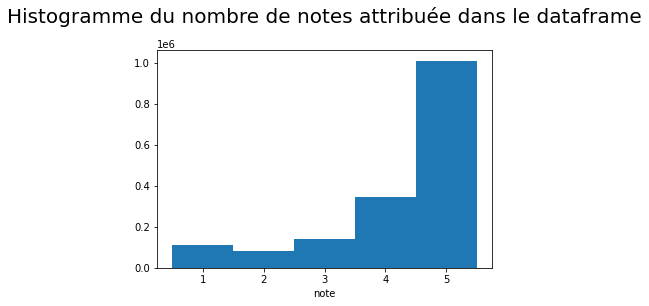

In [ ]:
# Histogramme pour voir la répartition des données entre les différentes notes

plt.hist(list(df['overall']), bins=np.arange(1,7)-0.5)
plt.title('Histogramme du nombre de notes attribuée dans le dataframe', y = 1.1, fontsize = 20)
plt.xticks(range(1,6))
plt.xlabel('note')
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



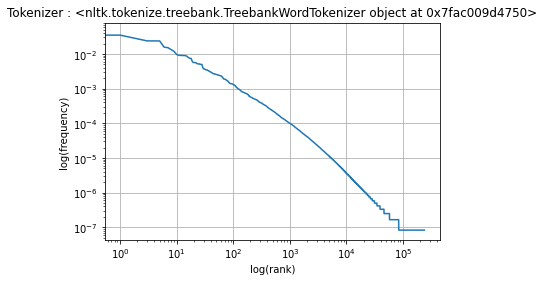

In [ ]:
# On vérifie si la loi de zipf est vérifiée

Ens_mots =  [x for X in df['reviewText'][:100000] for x in tok.tokenize(X) ]
c = Counter(Ens_mots)
print(c)

d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d.columns=['word', 'occurences']

nb_total = d.occurences.sum()
d['freq'] = d.occurences.apply(lambda x: x/nb_total)

d = d.sort_values('freq', ascending=False)
plt.figure()
plt.grid()
plt.xscale('log')  
plt.yscale('log')  
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)')
plt.title("Tokenizer : {0}".format(tok))
x = list(range(d.shape[0]))
plt.plot(x, d.freq)
plt.show()

On voit que la loi de Zipf est vérifiée

In [ ]:
# Tokenizer
tok = TreebankWordTokenizer()

In [ ]:
#On écrit une fonction qui permet de supprimer les stop words

nltk.download("stopwords")
#stop_words = unidecode(' '.join(set(stopwords.words('english'))))
def remove_sw(text):
  return([w for w in text if w not in list(set(stopwords.words('english')))])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
list(set(stopwords.words('english')))[:10]

['myself', 'she', "hadn't", 'be', 'can', 'there', 'mightn', 'whom', 'our', 'd']

In [ ]:
#On stock les reviews auxquelles on a enlevé les stop words et la ponctuation et qu'on ait tout passé en minuscule

rem_mots = []

tokenizer_punct = nltk.RegexpTokenizer(r"\w+")
for i in range(100000):
  rem_mots+=remove_sw(tokenizer_punct.tokenize(df.reviewText.iloc[i].lower()))

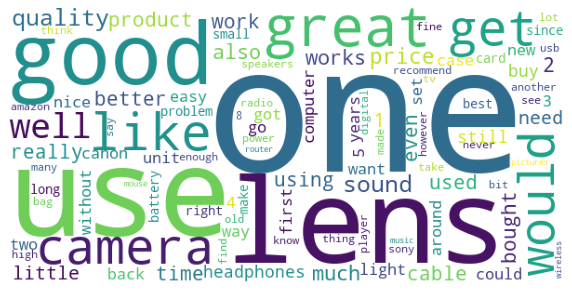

In [ ]:
# Image de mots pour le dataset en entier 

word_list = rem_mots
# On compte le nombre d'occurence de chaque entité 
word_count_dict=Counter(word_list)

wordcloud = WordCloud(background_color="white", max_words=100, 
                      width = 600, height = 300
                     )
                      
wordcloud.generate_from_frequencies(word_count_dict)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

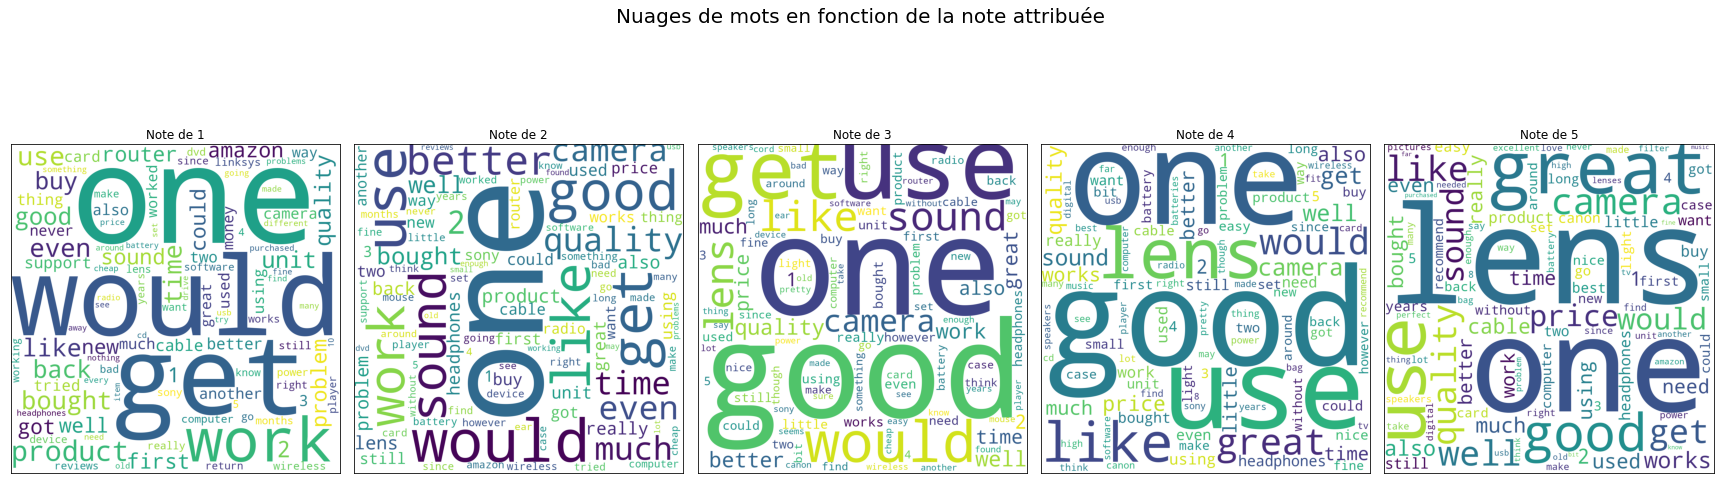

In [ ]:
df2 = df.iloc[:100000,]

# Image de mots en fonction de la note obtenue

fig, ax = plt.subplots(1,5,figsize = (24,12))
fig.suptitle('Nuages de mots en fonction de la note attribuée',fontsize=20, y = 0.85)

# Join all the tweet entities into one list
for k in range(5) : 
  #word_list = [j for i in df2[df2['overall']==(k + 1)]['reviewText']for j in tok.tokenize(i)]
  word_list = []
  X = df2[df2['overall']==(k + 1)].reset_index(drop=True)
  n = X.shape[0]
  for i in range(n):
    word_list+=remove_sw(tokenizer_punct.tokenize(X['reviewText'].iloc[i].lower()))
  # Count occurences of each entity 
  word_count_dict=Counter(word_list)

  wordcloud = WordCloud(background_color="white", max_words=100, 
                        width = 1200, height = 1200,
                        #mask=mask, contour_width=5, contour_color="skyblue"
                      )
                        
  wordcloud.generate_from_frequencies(word_count_dict)
  ax[k].imshow(wordcloud)
  ax[k].set_yticks([])
  ax[k].set_xticks([])
  ax[k].set_title('Note de ' + str(k +1 ))


#On trace la figure
plt.tight_layout() 

plt.show()

On voit que la part de good augmente beaucoup entre les notes 1 et 3 puis diminue un peu pour les notes 4 et 5 mais avec une augmentation de great en contrepartie. Ces nuages de mots sont donc rassurants pour la suite

On travaille sur un échantillon du jeu de donnée pour gagner en rapidité

In [ ]:
index = np.random.choice(df.shape[0],500000,replace= False)

In [ ]:
df2 = df.loc[index]


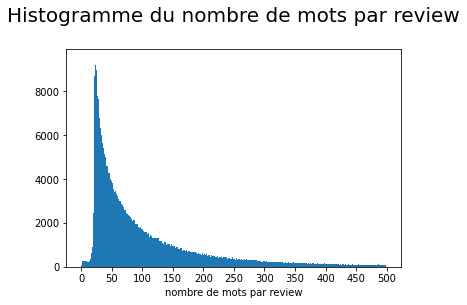

In [ ]:
# Repartition of the content lengths (words)
%matplotlib inline

data_histogramme = df2.reviewText.apply(lambda x: len(tok.tokenize(x)))
plt.hist(data_histogramme, bins=np.arange(1,500)-0.5)
plt.title('Histogramme du nombre de mots par review', y = 1.1, fontsize = 20)
plt.xticks(np.linspace(0,500,11))
plt.xlabel('nombre de mots par review')
plt.show()

In [ ]:
df2.reviewText.apply(lambda x: len(tok.tokenize(x))).median()

69.0

In [ ]:
df2.reviewText.apply(lambda x: len(tok.tokenize(x))).mean()

127.402698

La taille médiane des reviews est 69 et la taille moyenne est 127 (en nombre de mots), ces deux statistiques permettent de choisir le max_length et le padding que l'on va ajouter au review lors de la création du modèle

In [ ]:
df2.overall.value_counts()

5    298789
4    102810
3     42123
1     32126
2     24152
Name: overall, dtype: int64

In [ ]:
# Le réseau de neurones que nous allons implémenter dans dans la suite de ce code obtient de meilleurs résultats lorsque 
# les données sont équilibrées donc on rééquilibre les données grâce au code suivant 

index = np.random.choice(df[df["overall"]==1].shape[0],80000,replace= False)
df2 = df[df["overall"]==1].reset_index(drop=True).loc[index]
for i in range(2,6):
  index = np.random.choice(df[df["overall"]==i].shape[0],80000,replace= False)
  df2 = pd.concat([df2,df[df["overall"]==i].reset_index(drop=True).loc[index]])



In [ ]:
df2 = df2.sample(frac = 1).reset_index(drop=True)

In [ ]:
df2.overall.value_counts()

1    80000
5    80000
3    80000
4    80000
2    80000
Name: overall, dtype: int64

Les données sont maintenant équilibrées

### Préparation des données

In [ ]:
tok = TreebankWordTokenizer()

In [ ]:
#On utilise Cython pour accélerer la fonction tokenize_pad_numericalize car elle prend du temps
%load_ext Cython

In [ ]:
#On utilise la fonction du TD3 pour tokeniser et rajouter du padding. Comme la médiane des longueurs des reviews est de 69, 
#on fixe une max_lenght de 200 ce qui paraît acceptable, dans la majorité des cas on obtient la review entière

%%cython
def tokenize_pad_numericalize(entry, vocab_stoi,tok, max_length=200):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

In [ ]:
#On préfère utiliser GloVe qui prend moins de RAM que FastText
pretrained_vectors = GloVe(name="6B", dim='300')
#pretrained_vectors = FastText(language = 'en')

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:48<00:00, 8265.53it/s]


In [ ]:
# Ajout des token "<unk>" et '<pad>' et de leur embeddings au vocabulaire et aux embeddings de Glove

pretrained_vocab = vocab(pretrained_vectors.stoi, min_freq=0)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(2,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([400002, 300])

In [ ]:
# Renvoie l'index associé au token
pretrained_vocab.get_stoi()['<pad>']
pretrained_vocab.get_stoi()['<unk>']

0

In [ ]:
#Grâce à la fonction précédente on crée une nouvelle colonne avec les reviews tokenisées et auxquelles on a ajouté du padding
X = pretrained_vocab.get_stoi()
df2['review_tok']= df2['reviewText'].map(lambda e: tokenize_pad_numericalize(e, X,tok))
df2 = df2.drop(['reviewText'],axis=1)
df2 = df2.reset_index(drop=True)

In [ ]:
#On décale juste les classes de 1 pour qu'elles aillent de 0 à 4 pour concorder avec torch
df2['overall'] = df2['overall']-1

### LDA

In [ ]:
from gensim.models import LdaModel
from gensim import corpora
import nltk
nltk.download("wordnet")
from string import punctuation
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

punctuation = punctuation + '-"'

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
to_be_removed = list(en_stop) + list(punctuation)

tok = TreebankWordTokenizer()
# Tokenizing + removing stopwords
text_data = list(df2.reviewText.apply(lambda x: list(filter(lambda a: lemmatizer.lemmatize(a.lower()) not in to_be_removed,tok.tokenize(x)))).array)
print(text_data[0])
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=5)

In [ ]:
!pip install pyLDAvis


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

lda_display = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


On s'aperçoit que le LDA discrimine plus en fonction du type de produit que de l'avis du consommateur sur le produit.

Le cluster 5 représente les avis concernant les produits du type ordinateur

Le cluster 4 représente les avis positifs

Le cluster 3 représente les avis concernant les produits du type appareil photo

Le cluster 2 représente les avis concernant les produits du type télévision

Le cluster 1 représente les avis concernant les produits du type enceinte stéréo

### Réseau de neurones

In [ ]:
# On ajoute 5 hidden layer par rapport à ce qu'il y avait dans le TP

class Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Model, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.hidden_linear_layer2 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.hidden_linear_layer3 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.hidden_linear_layer4 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.hidden_linear_layer5 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = torch.nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        h  = torch.relu(self.hidden_linear_layer2( h ))
        h  = torch.relu(self.hidden_linear_layer3( h ))
        h  = self.dropout(h)
        h  = torch.relu(self.hidden_linear_layer4( h ))
        h  = torch.relu(self.hidden_linear_layer5( h ))

        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [ ]:
#On crée la classe qui va nous permettre de mettre le dataset dans le DataLoader

class TorchDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data.iloc[idx]['review_tok']),
          "label": np.array(self.data.iloc[idx]['overall'])
      }

      return item

In [ ]:
# Comme proportion pour les datasets on choisit un train dataset qui regoupe 70% des données, 
# un validation dataset qui en regroupe 20% et le reste pour le test dataset 
n = df2.shape[0]
m = int(n*0.7)
k = int(n*0.9)
args = {'bsize': 128}
train_dataloader = DataLoader(TorchDataset(df2[:m].reset_index(), args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
eval_dataloader = DataLoader(TorchDataset(df2[m:k].reset_index(), args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_dataloader = DataLoader(TorchDataset(df2[k:].reset_index(), args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
sizes = next(iter(train_dataloader))['text'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

64 200


In [ ]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 5 # because there is 5 classes, i.e. 5 notes
# we instanciate the model
#notation_model = Model(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [ ]:
notation_model

Model(
  (ebd): Embedding(400000, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (hidden_linear_layer2): Linear(in_features=300, out_features=300, bias=True)
  (hidden_linear_layer3): Linear(in_features=300, out_features=300, bias=True)
  (hidden_linear_layer4): Linear(in_features=300, out_features=300, bias=True)
  (hidden_linear_layer5): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_dataloader), desc="Epoch %s:" % (ep), total=train_dataloader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = torch.nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """
  if args['cuda'] != -1:
       model.cuda(args['cuda'])
       device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       args['device'] = device
       print("device set to %s" % (device) )
  else:
      args['device'] = 'cpu'
  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()
  device = 'cpu'
  # loop over the loader batches
  #for it, batch in tqdm(enumerate(train_dataloader), desc="Epoch %s:" % (ep), total=train_dataloader.__len__()):
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      b_counter = Counter(batch['label'].detach().cpu().tolist())
      b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = torch.nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [ ]:
#Cette fonction sert à vérifier s'il y a un GPU

if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))

DEVICE =  CPU


In [ ]:
def run_epochs(model, args):

  #args['device'] =device
  if args['cuda'] != -1:
       model.cuda(args['cuda'])
       device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       args['device'] = device
       print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", eval_dataloader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': -1, 'num_class': 5})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
#model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
notation_models = Model(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(notation_models, args)

device cpu


Epoch 0:: 100%|██████████| 4375/4375 [02:45<00:00, 26.37it/s]

Epoch 0/10 : Training : (loss 1.582429102407183) (acc 0.2594214285714286)



validation:: 100%|██████████| 1250/1250 [00:33<00:00, 37.79it/s]

validation : (loss 1.5702305693626404) (acc 0.2771375)



Epoch 1:: 100%|██████████| 4375/4375 [02:47<00:00, 26.08it/s]

Epoch 1/10 : Training : (loss 1.5477783568246024) (acc 0.3110107142857143)



validation:: 100%|██████████| 1250/1250 [00:32<00:00, 38.78it/s]

validation : (loss 1.5345855325698852) (acc 0.3308125)



Epoch 2:: 100%|██████████| 4375/4375 [02:46<00:00, 26.23it/s]

Epoch 2/10 : Training : (loss 1.5298451177052088) (acc 0.3348714285714286)



validation:: 100%|██████████| 1250/1250 [00:32<00:00, 37.91it/s]

validation : (loss 1.5200329962730408) (acc 0.347)



Epoch 3:: 100%|██████████| 4375/4375 [02:46<00:00, 26.28it/s]

Epoch 3/10 : Training : (loss 1.5254012564795358) (acc 0.3396142857142857)



validation:: 100%|██████████| 1250/1250 [00:32<00:00, 38.23it/s]

validation : (loss 1.5317138688087464) (acc 0.329075)



Epoch 4:: 100%|██████████| 4375/4375 [02:46<00:00, 26.28it/s]

Epoch 4/10 : Training : (loss 1.5218683369772774) (acc 0.34342142857142854)



validation:: 100%|██████████| 1250/1250 [00:32<00:00, 38.10it/s]

validation : (loss 1.513136816596985) (acc 0.3525125)



Epoch 5:: 100%|██████████| 4375/4375 [02:46<00:00, 26.30it/s]

Epoch 5/10 : Training : (loss 1.5181805311203003) (acc 0.3474714285714286)



validation:: 100%|██████████| 1250/1250 [00:31<00:00, 39.14it/s]

validation : (loss 1.5181595652580262) (acc 0.3473375)



Epoch 6:: 100%|██████████| 4375/4375 [02:49<00:00, 25.75it/s]

Epoch 6/10 : Training : (loss 1.5182674034663608) (acc 0.34787142857142855)



validation:: 100%|██████████| 1250/1250 [00:32<00:00, 38.37it/s]

validation : (loss 1.5154405285835266) (acc 0.3548)



Epoch 7:: 100%|██████████| 4375/4375 [02:51<00:00, 25.51it/s]

Epoch 7/10 : Training : (loss 1.5159237305232456) (acc 0.35132142857142856)



validation:: 100%|██████████| 1250/1250 [00:32<00:00, 38.78it/s]

validation : (loss 1.5182128352165223) (acc 0.3499875)



Epoch 8:: 100%|██████████| 4375/4375 [03:05<00:00, 23.55it/s]

Epoch 8/10 : Training : (loss 1.5156975153786796) (acc 0.3516964285714286)



validation:: 100%|██████████| 1250/1250 [00:32<00:00, 38.61it/s]

validation : (loss 1.507191758441925) (acc 0.362475)



Epoch 9:: 100%|██████████| 4375/4375 [02:57<00:00, 24.62it/s]

Epoch 9/10 : Training : (loss 1.5145706242152623) (acc 0.35336428571428574)



validation:: 100%|██████████| 1250/1250 [00:32<00:00, 38.30it/s]

validation : (loss 1.5481119331359863) (acc 0.321225)


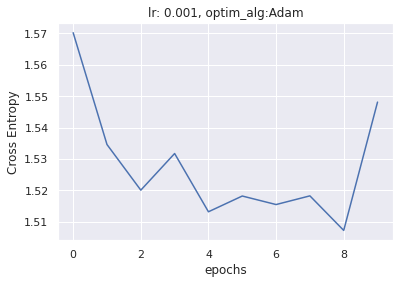

In [ ]:
%matplotlib inline

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

plot_loss(loss_list_val)

In [ ]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_dataloader, notation_models)

test:: 100%|██████████| 625/625 [00:20<00:00, 30.16it/s]

test : (loss 1.5461158472061156) (acc 0.322975)


In [ ]:
for t, p in zip(trues[:10], preds[:10]):
  correct = colored('Correct', 'green') if t == p else colored('Mistake', 'red')
  print('true', t+1, 'predicted', p+1, correct)

true 1 predicted 1 Correct
true 2 predicted 1 Mistake
true 2 predicted 4 Mistake
true 2 predicted 2 Correct
true 2 predicted 5 Mistake
true 3 predicted 1 Mistake
true 3 predicted 1 Mistake
true 1 predicted 1 Correct
true 3 predicted 1 Mistake
true 4 predicted 1 Mistake


In [ ]:
names = ["1","2","3","4","5"]
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

           1       0.30      0.75      0.42      8156
           2       0.28      0.15      0.19      7953
           3       0.32      0.21      0.26      8058
           4       0.33      0.15      0.20      7911
           5       0.44      0.34      0.38      7922

    accuracy                           0.32     40000
   macro avg       0.33      0.32      0.29     40000
weighted avg       0.33      0.32      0.29     40000



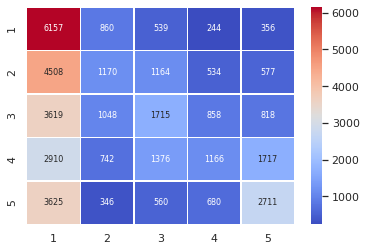

In [ ]:
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

### Conclusion

Dans ce projet nous avons essayé de prédire les notes attibuée à des produits électroniques à partir des reviews des utilisateurs. 

Après avoir constaté via des statistqiues descriptives les différences de vocabulaire entre les différentes notes, nous avons créé un modèle de deep learning qui se base sur des embeddings de dimmensions 300 disponible via Glove. Enfin nous avons ajouté plusieurs couches pour essayer de tirer profit des ces embeddings.

Les résultats obtenus ne sont pas très concluants (accuracy de 0.32) il faudrait faire de l'optimisation sur le learning rate ou peut être complexifier le réseau notamment les dimensions des couches.